<a href="https://colab.research.google.com/github/tayiba-r/tayiba_INFO5731_SPRING2023/blob/main/final_project/python_file/Aspect_based_review_summarization_for_software_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Prepare libraries and notebook settings

In [25]:
import pandas as pd
import numpy as np
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import seaborn as sns

from textblob import TextBlob
from wordcloud import WordCloud
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [26]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import warnings
warnings.filterwarnings('ignore')

# set display options to show all columns
pd.set_option('display.max_columns', None)


### Prepare the datasets

In [28]:
# load datasets
df_AgileCRMReviewspickle = pd.read_csv("AgileCRMReviewspickle.csv")
df_BullhornATSCRMReviewspickle = pd.read_csv("BullhornATSCRMReviewspickle.csv")
df_HubSpotCRMReviewspickle = pd.read_csv("HubSpotCRMReviewspickle.csv")
df_LessAnnoyingCRMReviewspickle = pd.read_csv("LessAnnoyingCRMReviewspickle.csv")
df_MaximizerCRMReviewspickle = pd.read_csv("MaximizerCRMReviewspickle.csv")
df_NetSuiteCRMReviewspickle = pd.read_csv("NetSuiteCRMReviewspickle.csv")
df_ReallySimpleSystemsCRMReviewspickle = pd.read_csv("ReallySimpleSystemsCRMReviewspickle.csv")
df_SugarCRMReviewspickle = pd.read_csv("SugarCRMReviewspickle.csv")
df_VtigerCRMReviewspickle = pd.read_csv("VtigerCRMReviewspickle.csv")
df_ZohoCRMReviewspickle = pd.read_csv("ZohoCRMReviewspickle.csv")

In [29]:
# add software column to all datasets
df_AgileCRMReviewspickle["software"] = "Agile CRM"
df_BullhornATSCRMReviewspickle["software"] = "Bullhorn ATS CRM"
df_HubSpotCRMReviewspickle["software"] = "HubSpot CRM"
df_LessAnnoyingCRMReviewspickle["software"] = "Less Annoying CRM"
df_MaximizerCRMReviewspickle["software"] = "Maximizer CRM"
df_NetSuiteCRMReviewspickle["software"] = "NetSuite CRM"
df_ReallySimpleSystemsCRMReviewspickle["software"] = "Really Simple Systems CRM"
df_SugarCRMReviewspickle["software"] = "Sugar CRM"
df_VtigerCRMReviewspickle["software"] = "Vtiger CRM"
df_ZohoCRMReviewspickle["software"] = "Zoho CRM"

In [30]:
# merge the dataframes

# create a list of dataframes to concatenate
dfs = [df_AgileCRMReviewspickle.iloc[:, 1:],
       df_BullhornATSCRMReviewspickle.iloc[:, 1:],
       df_HubSpotCRMReviewspickle.iloc[:, 1:], 
       df_LessAnnoyingCRMReviewspickle.iloc[:, 1:], 
       df_MaximizerCRMReviewspickle.iloc[:, 1:], 
       df_NetSuiteCRMReviewspickle.iloc[:, 1:], 
       df_ReallySimpleSystemsCRMReviewspickle.iloc[:, 1:], 
       df_SugarCRMReviewspickle.iloc[:, 1:], 
       df_VtigerCRMReviewspickle.iloc[:, 1:], 
       df_ZohoCRMReviewspickle.iloc[:, 1:]
      ]

# concatenate the dataframes
df_merged = pd.concat(dfs, ignore_index=True)

# shuffle the dataframe
df_merged = df_merged.sample(frac=1).reset_index(drop=True)

### Data cleaning and EDA

In [31]:
# check the shape
df_merged.shape

(8234, 30)

In [32]:
# check the merged dataframe
df_merged.head()

,id,status,global_review_id,hash_global_review_id,listing_id,title,is_rating,score,created,content,pros,cons,vendor_reply_text,OverAllRating,Value For Money,Ease of Use,Features,Customer Support,Likelihood to recommned,isAnonymous,is_verified,full_name,picture_url,company_industry,company_size,frequency_of_use,time_used,source,incentivized,software
0,2110763,Published,Capterra___1295135,1641a422e5,9908,An affordable CRM,False,4.462893,2019-01-17,We're quite happy as it's the first CRM with w...,It's quite affordable and lightweight CRM with...,We're just concerned about the contact managem...,NaN,4,5.0,5.0,3.0,4.0,7,False,False,Gourav M.,https://cdn0.capterra-static.com/profile-image...,Human Resources,51-200,daily,6-12 months,Capterra,NominalGift,Zoho CRM
1,1422899,Published,Capterra___1002982,83e2c381a4,20482,Good CRM,False,4.462893,2018-08-02,NaN,I like the ease of use and I like the help but...,The customer support for more in-depth issues....,NaN,4,4.0,4.0,4.0,2.0,7,False,False,Kristina D.,NaN,Machinery,51-200,daily,2+ years,Capterra,NominalGift,Maximizer CRM
2,1793189,Published,Capterra___1165928,b5950a110f,102533,Great option for almost everything we want to do.,False,4.462893,2018-11-13,NaN,HubSpot has been great for building and schedu...,A lot of features have steep learning curves a...,NaN,4,5.0,4.0,4.0,5.0,8,True,False,Anonymous Reviewer,NaN,Food & Beverages,11-50,daily,1-2 years,Capterra,VendorReferredIncentivized,HubSpot CRM
3,7172191,Published,SoftwareAdvice___2526206,40ef71af87,102533,VERY STEEP LEARNING CURVE,False,4.462893,2020-11-23,NaN,The vast amount of integrations that HubSpot a...,While it's extremely clear that the platform i...,NaN,3,0.0,1.0,4.0,3.0,5,False,False,Morgan J.,NaN,Computer Software,11-50,daily,Less than 6 months,SoftwareAdvice,NoIncentive,HubSpot CRM
4,1825177,Published,Capterra___1180103,69324b06eb,102533,"A bit clunky, but gets the job done",False,4.462893,2018-11-19,NaN,"It has streamlined our CRM efforts, which has ...",It's a little clunky and requires some knowled...,NaN,3,0.0,3.0,3.0,0.0,5,True,False,Anonymous Reviewer,NaN,Marketing and Advertising,1-10,other,1-2 years,Capterra,NominalGift,HubSpot CRM


In [33]:
# check distinct ratings
distinct_scores = df_merged['OverAllRating'].unique()
print(distinct_scores)

[4 3 5 2 1]


<Axes: xlabel='OverAllRating', ylabel='count'>

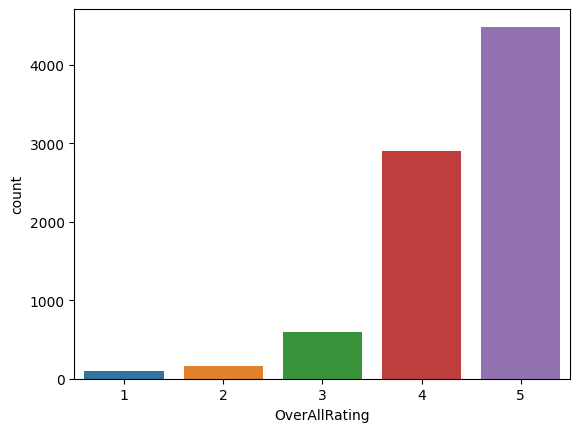

In [34]:
# visualize
sns.countplot(x='OverAllRating', data=df_merged)

In [35]:
df_merged.columns

Index(['id', 'status', 'global_review_id', 'hash_global_review_id',
       'listing_id', 'title', 'is_rating', 'score', 'created', 'content',
       'pros', 'cons', 'vendor_reply_text', 'OverAllRating', 'Value For Money',
       'Ease of Use', 'Features', 'Customer Support',
       'Likelihood to recommned', 'isAnonymous', 'is_verified', 'full_name',
       'picture_url', 'company_industry', 'company_size', 'frequency_of_use',
       'time_used', 'source', 'incentivized', 'software'],
      dtype='object')

In [36]:
#retain only important columns
merged_df = df_merged.loc[:, ['title',  
                              'content', 
                              'pros', 
                              'cons', 
                              'OverAllRating', 
                              'Value For Money',       
                              'Ease of Use', 
                              'Features', 
                              'Customer Support',
                              'Likelihood to recommned',
                              'is_verified', 
                              'company_industry', 
                              'company_size', 
                              'frequency_of_use', 
                              'time_used', 
                              'software'
                              ]
                          ]

In [37]:
# add review column
def select_review(row):
    if row["OverAllRating"] >= 4:
        return row["pros"]
    elif row["OverAllRating"] <= 2:
        return row["cons"]
    else:
        return row["content"]

df_merged["review"] = df_merged.apply(select_review, axis=1)

In [38]:
# add review column
def select_rating(row):
    if row["OverAllRating"] >= 4:
        return "GOOD"
    elif row["OverAllRating"] <= 2:
        return "BAD"
    else:
        return "NEUTRAL"

df_merged["rating"] = df_merged.apply(select_rating, axis=1)

<Axes: xlabel='rating', ylabel='count'>

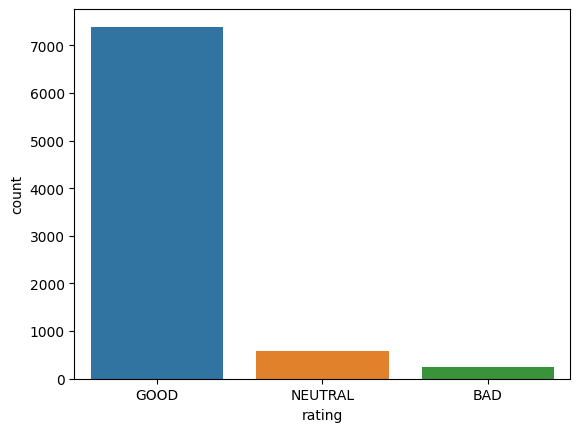

In [39]:
# visualize
sns.countplot(x='rating', data=df_merged)


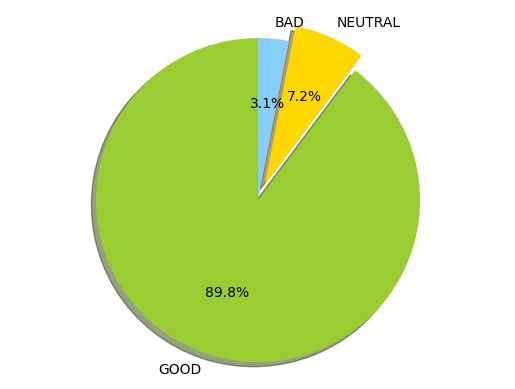

In [40]:
labels = df_merged['rating'].unique()
sizes = df_merged['rating'].value_counts()
colors = ['yellowgreen', 'gold', 'lightskyblue']
explode = (0, 0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.show()


In [41]:
# now drop redundant columns
df_merged = df_merged.drop(columns=['content', 'pros', 'cons'])

In [42]:
# re-order the columns
df_merged = df_merged.reindex(columns=['software', 'company_industry', 'company_size', 'title', 'frequency_of_use', 'time_used', 'review', 'rating', 'OverAllRating', 'Value For Money', 'Ease of Use', 'Features', 'Customer Support', 'Likelihood to recommned', 'is_verified'])

In [43]:
# drop null values
df_merged.dropna(inplace=True)

In [44]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6432 entries, 0 to 8231
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   software                 6432 non-null   object 
 1   company_industry         6432 non-null   object 
 2   company_size             6432 non-null   object 
 3   title                    6432 non-null   object 
 4   frequency_of_use         6432 non-null   object 
 5   time_used                6432 non-null   object 
 6   review                   6432 non-null   object 
 7   rating                   6432 non-null   object 
 8   OverAllRating            6432 non-null   int64  
 9   Value For Money          6432 non-null   float64
 10  Ease of Use              6432 non-null   float64
 11  Features                 6432 non-null   float64
 12  Customer Support         6432 non-null   float64
 13  Likelihood to recommned  6432 non-null   int64  
 14  is_verified             

In [45]:
# preview cleaned dataframe
df_merged.head()

,software,company_industry,company_size,title,frequency_of_use,time_used,review,rating,OverAllRating,Value For Money,Ease of Use,Features,Customer Support,Likelihood to recommned,is_verified
0,Zoho CRM,Human Resources,51-200,An affordable CRM,daily,6-12 months,It's quite affordable and lightweight CRM with...,GOOD,4,5.0,5.0,3.0,4.0,7,False
1,Maximizer CRM,Machinery,51-200,Good CRM,daily,2+ years,I like the ease of use and I like the help but...,GOOD,4,4.0,4.0,4.0,2.0,7,False
2,HubSpot CRM,Food & Beverages,11-50,Great option for almost everything we want to do.,daily,1-2 years,HubSpot has been great for building and schedu...,GOOD,4,5.0,4.0,4.0,5.0,8,False
5,Zoho CRM,Real Estate,1-10,Robust system for receivables and more,daily,6-12 months,This system is what we use to handle work orde...,GOOD,5,0.0,5.0,5.0,0.0,10,False
6,Less Annoying CRM,Insurance,myself only,My Less Annoying experience,daily,6-12 months,Once I figured out how to navigate the ease of...,GOOD,5,5.0,5.0,5.0,0.0,10,False


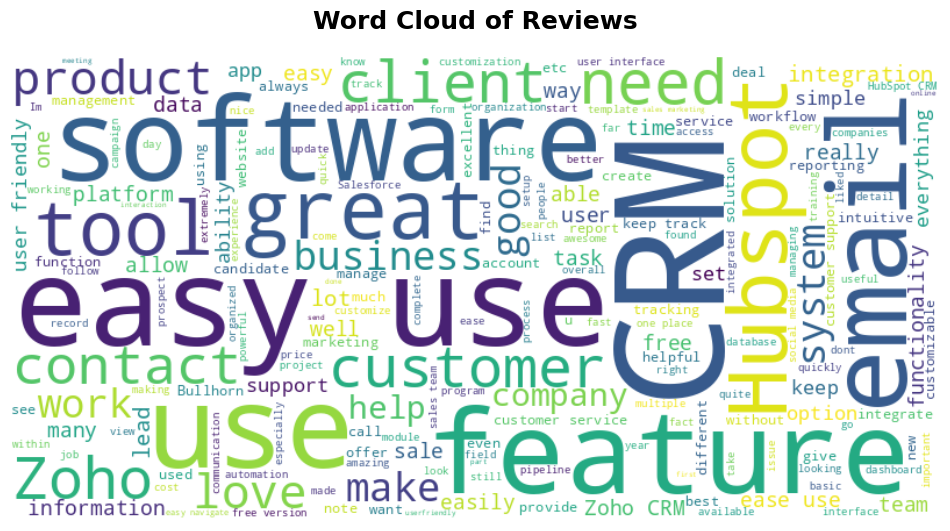

In [46]:
# Define the regular expression pattern to match special characters
pattern = r'[^a-zA-Z0-9\s]'

# Remove special characters from the merged_review_body column
df_merged['review'] = df_merged['review'].apply(lambda x: re.sub(pattern, '', x))

# Removing stopwords
df_merged['review'] = df_merged['review'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Define the text data
text_data = ' '.join(df_merged['review'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text_data)

# Display the word cloud
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews', fontweight='bold', fontsize=18, pad=20)
plt.show()

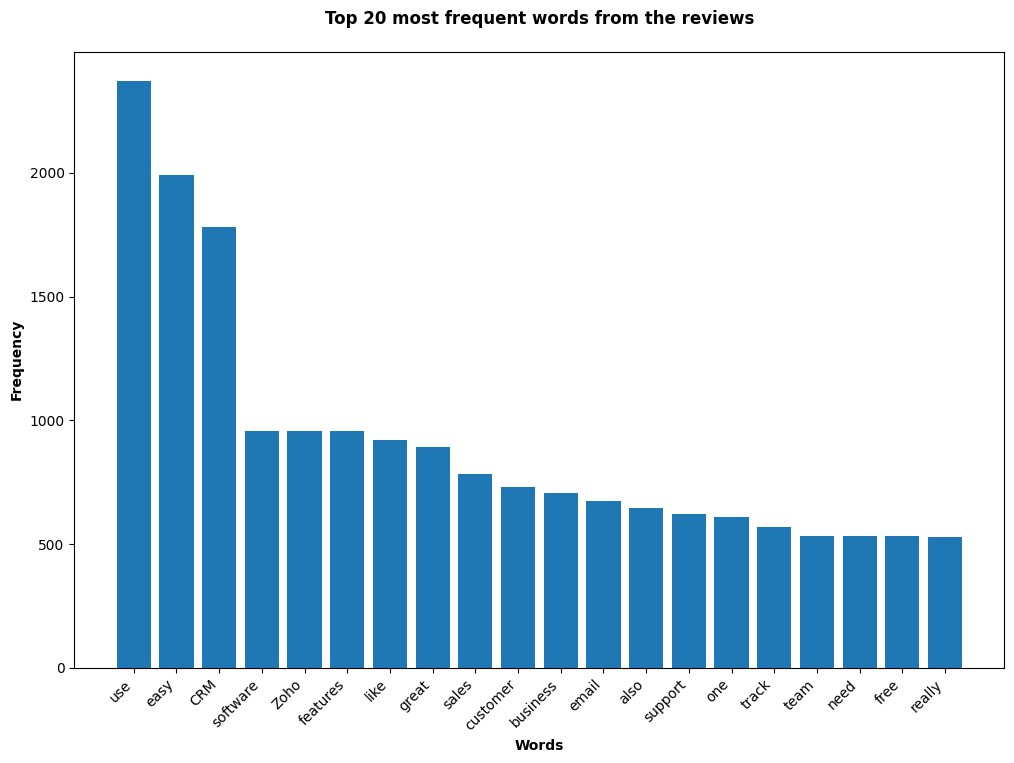

In [47]:
# Generate bar chart
word_counts = pd.Series(text_data.split()).value_counts()[:20]
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(word_counts.index, word_counts.values)
plt.title('Top 20 most frequent words from the reviews', fontweight='bold', pad=20)
plt.xlabel('Words', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.show()


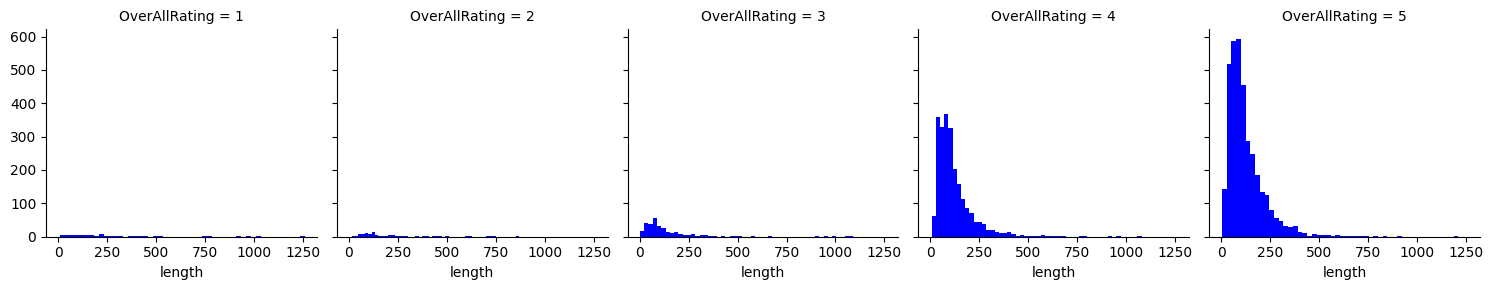

In [48]:
# add length column
df_merged['length'] = df_merged['review'].apply(len)

# compare length ot overall rating
graph = sns.FacetGrid(data=df_merged, col='OverAllRating')

graph.map(plt.hist,'length',bins=50,color='blue')

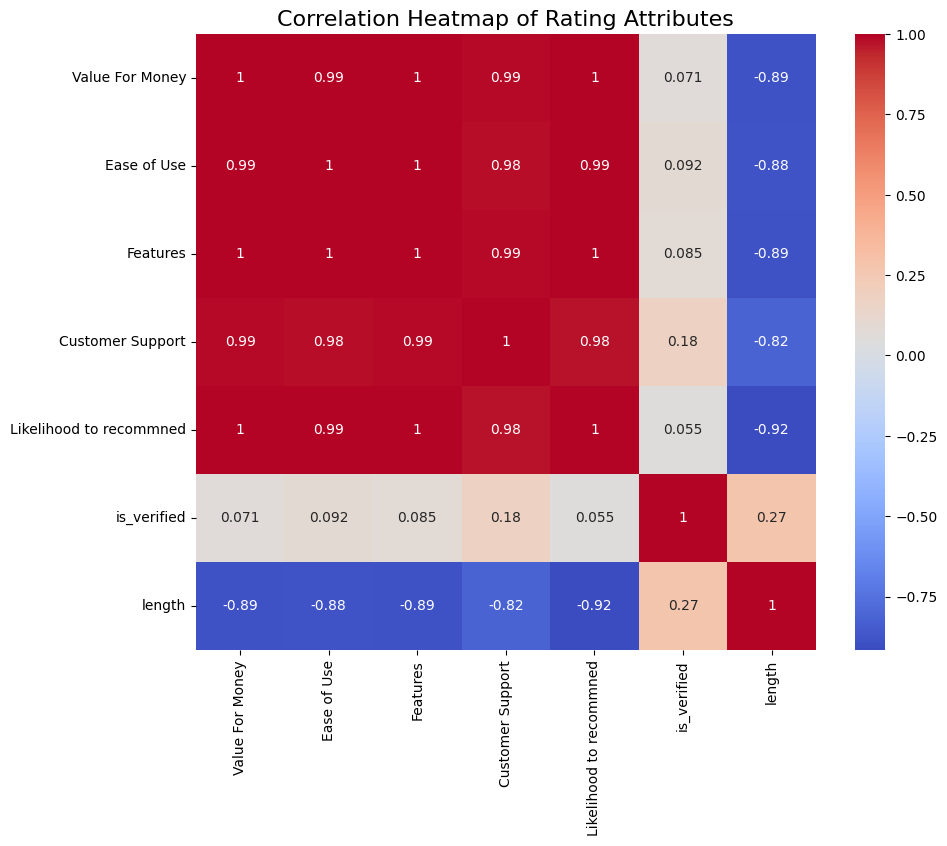

In [49]:
# Get the mean values of the vote columns w.r.t the stars on the review
star_values = df_merged.groupby('OverAllRating').mean()

# Compute the correlation matrix
corr_matrix = star_values.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap of Rating Attributes', fontsize=16)
plt.show()


In [50]:
# Seperate the dataset into X and Y for prediction
x = df_merged['review']
y = df_merged['rating']
print("X = ", x.shape)
print("y = ", y.shape)

X =  (6432,)
y =  (6432,)


In [51]:
# clean reviews
def text_process(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# convert to vectors
vocab = CountVectorizer(analyzer=text_process).fit(x)
len(vocab.vocabulary_)

9462

In [52]:
# Transform text data into a matrix of token counts
x = vocab.transform(x)

# Get the shape of the sparse matrix
num_rows, num_cols = x.shape
print("Shape of the sparse matrix: {} rows x {} columns".format(num_rows, num_cols))

# Get the number of non-zero occurrences in the matrix
num_nonzero = x.nnz
print("Number of non-zero occurrences: ", num_nonzero)

# Calculate the density of the matrix as a percentage
density = (num_nonzero / (num_rows * num_cols)) * 100
print("Density of the matrix: {:.2f}%".format(density))


Shape of the sparse matrix: 6432 rows x 9462 columns
Number of non-zero occurrences:  107018
Density of the matrix: 0.18%


In [53]:
# create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=33)

### Random Forest Model application

In [54]:
# Initialize and fit the classifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)

# Use the trained classifier to make predictions on the test set
y_pred_rfc = rfc.predict(x_test)

# Print the confusion matrix for the predicted and actual test set values
print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_test, y_pred_rfc))

# Print the accuracy score of the model
print("Score:", round(accuracy_score(y_test, y_pred_rfc) * 100, 2))

# Print the classification report of the model
print("Classification Report:", classification_report(y_test, y_pred_rfc))


Confusion Matrix for Random Forest Classifier:
[[   2   27    0]
 [   0 1188    1]
 [   1   64    4]]
Score: 92.77
Classification Report:               precision    recall  f1-score   support

         BAD       0.67      0.07      0.12        29
        GOOD       0.93      1.00      0.96      1189
     NEUTRAL       0.80      0.06      0.11        69

    accuracy                           0.93      1287
   macro avg       0.80      0.38      0.40      1287
weighted avg       0.92      0.93      0.90      1287



### Testing

In [55]:
# test
print(f"USER REVIEW: {df_merged.loc[0, 'review']}")
print(f"USER RATING: {df_merged.loc[0, 'rating']}")

prediction = vocab.transform([df_merged.loc[0, 'review']])
print(f"PREDICTION : {rfc.predict(prediction)[0]}\n")

USER REVIEW: quite affordable lightweight CRM essential features tools need run business
USER RATING: GOOD
PREDICTION : GOOD



In [56]:
# extra tests
test_reviews = [
    "The worst application ever. I don't like it at all",
    "The application was wonderfully designed. The experience is just amazing",
    "Boring user interface. Very slow and unresponsive",
    "I am very pleased with the wonderful work done to improve the CRM from the previous version. Thank you soo much",
    "I won't say I had a bad experience. However, I am totally confused with the results"
]

# test
for i, review in enumerate(test_reviews, 1):
    print(f"Test {i}:")
    print(f"\tTEST REVIEW: {review}")

    prediction = vocab.transform([review])
    print(f"\tPREDICTION : {rfc.predict(prediction)[0]}\n")

Test 1:
	TEST REVIEW: The worst application ever. I don't like it at all
	PREDICTION : BAD

Test 2:
	TEST REVIEW: The application was wonderfully designed. The experience is just amazing
	PREDICTION : GOOD

Test 3:
	TEST REVIEW: Boring user interface. Very slow and unresponsive
	PREDICTION : BAD

Test 4:
	TEST REVIEW: I am very pleased with the wonderful work done to improve the CRM from the previous version. Thank you soo much
	PREDICTION : GOOD

Test 5:
	TEST REVIEW: I won't say I had a bad experience. However, I am totally confused with the results
	PREDICTION : GOOD



### Observations

The data was biased towards positive reviews. As visualized, most reviews container ratings for more than 3 stars.  

More than 92% of the reviews were positive ones with only around 2% of the reviews being negative. This was not fair for the model and as a result most of the predictions are likely to be biased towards positivity.

In future, larger datasets are recommended containing uniformly spread reviews. This is considered the best alternative to reducing the biasness as compared to reducing the number of the positive reviews in the current dataset to match that of negative ones.

However, the model was able to perform well and obtain a higher percentage of accuracy i.e. 92.93%. It was also able to classify reviews based on the 3 primary classes defined: GOOD, NEUTRAL and BAD.

## Now we will find out which is the best application among all the applications. We will loop through a zip file.

In [57]:
import zipfile
import pandas as pd
import numpy as np
import nltk
import string
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [58]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [59]:
# Step 1: Extract the files from the zip archive
zip_path = '/content/CRM_Reviews_Datasets.zip'
extract_path = 'content/extracted_dataset/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Step 2: Perform aspect-based opinion summarization
aspect_summaries = {}

# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define punctuation and stopwords
punctuation = set(string.punctuation)
stopwords = set(stopwords.words('english'))

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()


In [60]:
# Iterate over extracted CSV files
for file_name in zip_ref.namelist():
    if file_name.endswith('.csv'):
        csv_file_path = f'{extract_path}/{file_name}'
        
        # Read the CSV file
        #df = pd.read_csv(csv_file_path)
        df = pd.read_csv(csv_file_path, encoding='ISO-8859-1')
        
        # Clean the data
        if 'pros' in df.columns:
            df['pros'].fillna('0', inplace=True)
            df['pros'] = df['pros'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(str(x)) if word.lower() not in stopwords and word.lower() not in punctuation]))
        
        if 'cons' in df.columns:
            df['cons'].fillna('0', inplace=True)
            df['cons'] = df['cons'].apply(lambda x: ' '.join([word.lower() for word in word_tokenize(str(x)) if word.lower() not in stopwords and word.lower() not in punctuation]))
        
        if 'OverAllRating' in df.columns:
            df['OverAllRating'].fillna(0, inplace=True)
        
        # Iterate over rows and extract aspects and opinions
        for index, row in df.iterrows():
            aspect = file_name  # Use the file name as the aspect
            pros_opinion = row.get('pros', '')
            cons_opinion = row.get('cons', '')
            overall_rating = row.get('OverAllRating', 0)
            
            # Step 3: Extract sentiment from opinions
            pros_sentiment_scores = sid.polarity_scores(pros_opinion)
            pros_sentiment = pros_sentiment_scores['compound']
            
            cons_sentiment_scores = sid.polarity_scores(cons_opinion)
            cons_sentiment = cons_sentiment_scores['compound']
                        # Step 4: Aggregate opinions for each aspect
            if aspect in aspect_summaries:
                aspect_summaries[aspect]['pros'].append(pros_opinion)
                aspect_summaries[aspect]['pros_sentiments'].append(pros_sentiment)
                aspect_summaries[aspect]['cons'].append(cons_opinion)
                aspect_summaries[aspect]['cons_sentiments'].append(cons_sentiment)
                aspect_summaries[aspect]['overall_ratings'].append(overall_rating)
            else:
                aspect_summaries[aspect] = {
                    'pros': [pros_opinion],
                    'pros_sentiments': [pros_sentiment],
                    'cons': [cons_opinion],
                    'cons_sentiments': [cons_sentiment],
                    'overall_ratings': [overall_rating]
                }


In [61]:
# Perform sentiment analysis on the extracted data
for aspect, summary in aspect_summaries.items():
    pros_opinions = summary['pros']
    cons_opinions = summary['cons']

    # Step 5: Perform sentiment analysis on pros opinions
    pros_sentiments = []
    for opinion in pros_opinions:
        sentiment_scores = sid.polarity_scores(opinion)
        sentiment = sentiment_scores['compound']
        pros_sentiments.append(sentiment)
    
    # Step 6: Perform sentiment analysis on cons opinions
    cons_sentiments = []
    for opinion in cons_opinions:
        sentiment_scores = sid.polarity_scores(opinion)
        sentiment = sentiment_scores['compound']
        cons_sentiments.append(sentiment)
    
    # Calculate average sentiment and overall rating
    avg_pros_sentiment = np.mean(pros_sentiments)
    avg_cons_sentiment = np.mean(cons_sentiments)
    avg_overall_rating = np.mean(summary['overall_ratings'])
    
    # Select the best application based on sentiment analysis
    best_app = None
    if avg_pros_sentiment > avg_cons_sentiment:
        best_app = 'pros'
        best_sentiment = avg_pros_sentiment
    else:
        best_app = 'cons'
        best_sentiment = avg_cons_sentiment

In [62]:
# Print the best application for each feature based on sentiment analysis
for aspect, summary in aspect_summaries.items():
    pros_sentiments = summary['pros_sentiments']
    cons_sentiments = summary['cons_sentiments']
    overall_ratings = summary['overall_ratings']
    pros_opinions = summary['pros'][:100]  # Limit to the first 100 opinions
    pros_sentiments = summary['pros_sentiments'][:100]
    pros_avg_sentiment = sum(pros_sentiments) / len(pros_sentiments)
    
    cons_opinions = summary['cons'][:100]  # Limit to the first 100 opinions
    cons_sentiments = summary['cons_sentiments'][:100]
    cons_avg_sentiment = sum(cons_sentiments) / len(cons_sentiments)
    # Calculate average sentiment and overall rating
    avg_pros_sentiment = np.mean(pros_sentiments)
    avg_cons_sentiment = np.mean(cons_sentiments)
    avg_overall_rating = np.mean(overall_ratings)
    
    # Select the best application based on sentiment analysis
    best_app = None
    if avg_pros_sentiment > avg_cons_sentiment:
        best_app = 'pros'
        best_sentiment = avg_pros_sentiment
    else:
        best_app = 'cons'
        best_sentiment = avg_cons_sentiment

In [63]:
import os

aspect_name = os.path.splitext(aspect)[0]
name_of_application = os.path.basename(aspect_name)
print(name_of_application) 


ZohoCRMReviewspickle


In [64]:
print("Among all the CRM applications below application is most recommended\n")

print(f'Name of the application   : {name_of_application}')
print(f'Pros Opinions             : {pros_opinions}')
print(f'Sentiment Score           : {best_sentiment}')
print(f'Overall Rating            : {avg_overall_rating}')

Among all the CRM applications below application is most recommended

Name of the application   : ZohoCRMReviewspickle
Pros Opinions             : ["zoho crm low cost great small businesses easy manage leads keep track 's success features easy highly understandable really recommend", 'love pricing zoho products small startup like mine could use tools compete big guys â\x80\x94 problem // also love take extra step developing apps good mobile experience', 'suite zoho apps integrates', 'bells whistles help structuring using customer data breeze crm customizable tailored specific needs massive time-saving thanks native integration 40+ apps', 'start talking zoho crm would say balanced easy easy use anyone little knowledge important feature think control users roles permissions allows access system safely interesting follow contact companies management suppliers facilitates communication daily work company another point favor management tasks events customer service facilitates tracking forg